# Установка библиотек

In [ ]:
!pip3 install hazardous@git+https://github.com/soda-inria/hazardous
!pip3 install pycox
!pip3 install scikit-survival

  Cloning https://github.com/soda-inria/hazardous to /private/var/folders/5x/6m24bsfj487bwk8kdp77nxy40000gn/T/pip-install-qtl7ltow/hazardous_4b66a3d9d5f6404b8c10b2bad67906ee
  Running command git clone --filter=blob:none --quiet https://github.com/soda-inria/hazardous /private/var/folders/5x/6m24bsfj487bwk8kdp77nxy40000gn/T/pip-install-qtl7ltow/hazardous_4b66a3d9d5f6404b8c10b2bad67906ee
  Resolved https://github.com/soda-inria/hazardous to commit f75d272d542e20298b5a33545e6717b4bd03c35d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hazardous: filename=hazardous-0.1.0.dev0-py3-none-any.whl size=43392 sha256=c399053598ab265a25f1d246730116dfe1231de68518eeb31e47d6c76013f0da
  Stored in directory: /private/var/folders/5x/6m24bsfj487bwk8kdp77nxy40000gn/T/pip-ephem-wheel-cache-iskfli20/wheels/b7/f6/61/6ae21b38a23b035e6503db86d4f260c84843239189

In [ ]:
!pip3 install torch torchvision torchaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 MB 8.9 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.1 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 9.6 MB/s eta 0:00:0000:0100:01m

[notice] A new release of pip is available: 23.1.2 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip


In [1]:
from datetime import datetime
from functools import reduce
from hazardous import SurvivalBoost
from hazardous.metrics import integrated_brier_score_survival, integrated_brier_score_incidence
from lifelines import AalenJohansenFitter
from lifelines.utils import concordance_index
from pycox.evaluation import EvalSurv
from pycox.models import DeepHit
from pycox.preprocessing.label_transforms import LabTransDiscreteTime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sksurv.metrics import check_y_survival, CensoringDistributionEstimator
from sksurv.metrics import cumulative_dynamic_auc
from sksurv.util import Surv
from typing import List
from zipfile import ZipFile
import io
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import torch
import torchtuples as tt
import warnings

# Подготовка данных

In [2]:
warnings.filterwarnings('ignore')

In [3]:
ibs = {}

In [4]:
dtypes = {'credit_score': 'Int16', 'first_payment_date': 'str', 'first_time_homebuyer_flag': 'str',
        'maturity_date': 'str', 'MSA': 'Int32', 'MI_%': 'Int16', 'units_numb': 'Int8', 'occupancy_status': 'str',
        'CLTV': 'Int16', 'DTI_ratio': 'Int16', 'orig_UPB': 'Int64', 'LTV': 'Int16', 'orig_interest_rate': 'str',
        'channel': 'str', 'PPM_flag': 'str', 'amortization_type': 'str',
        'property_state': 'str', 'property_type': 'str', 'postal_code': 'Int32', 'id_loan': 'str',
        'loan_purpose': 'str', 'orig_loan_term': 'Int16', 'borrowers_num': 'Int8', 'seller_name': 'str',
        'service_name': 'str', 'super_conf_flag': 'str', 'id_loan_preharp': 'str',
        'program_ind': 'str', 'HARP_ind': 'str', 'property_val_method': 'Int64',
        'int_only_flag': 'str', 'MI_cancel_flag': 'str', 'orig_interest_rate':'float32'}

static = ['credit_score', 'first_time_homebuyer_flag', 'units_numb', 'MSA', 'MI_%', 'occupancy_status', 'CLTV', 'DTI_ratio', 'orig_UPB',
       'LTV', 'orig_interest_rate', 'channel', 'PPM_flag', 'amortization_type',
       'property_state', 'zero_balance_code', 'property_type', 'loan_purpose', 'orig_loan_term', 'borrowers_num', 'super_conf_flag',
       'int_only_flag', 'property_val_method']

categ = ['occupancy_status', 'first_time_homebuyer_flag', 'channel', 'PPM_flag', 'amortization_type',
       'property_state', 'borrowers_num', 'int_only_flag', 'property_val_method', 'modification_flag', 'step_mod_flag', 'deferred_payment_plan',
         'ELTV', 'delinq_due_disaster', 'borrowe_asistance_stat_code', 'property_type', 'loan_purpose', 'super_conf_flag']

def get_y(cens, time):
    cens, time = np.array(cens), np.array(time)
    y = np.empty(dtype=[('event', int), ('duration', np.float64)], shape=cens.shape[0])
    y['event'] = cens
    y['duration'] = time
    return y


def get_y_event(y_, events: List=[]):
    y = np.empty(dtype=[('event', bool), ('duration', np.float64)], shape=y_.shape[0])
    y['event'] = y_.event.isin(events)
    y['duration'] = y_.duration
    return y

def transform_timegrid(curves, time, grid):
    """
      curves - current survival function(s)
      time - current time grid
      grid - new time grid
    """
    idx = np.searchsorted(grid, time[::-1])
    if len(curves.shape)==1:
      new = np.full(len(curves), None)
      new[idx[::-1]] = curves
      return pd.DataFrame(new).replace(to_replace=None, method='ffill').values
    elif len(curves.shape)==2:
      idx = idx[::-1]
      new = np.full(curves.shape, None)
      row = np.repeat(np.arange(new.shape[0]), idx.shape[0])
      col = np.tile(idx, new.shape[0])
      new[row, col] = curves.ravel()
      return pd.DataFrame(new.T).replace(to_replace=None, method='ffill').values.T

    else:
      return None

def transform_curves(curves): # noninc
  """
    - curves - current survvial_function(s)
    -------
    Returns:
    - array of nonincreasing survival function(s)
  """
  if len(curves.shape) == 1: curves = curves[None, :]
  return np.array(list(map(lambda tmp:
                           reduce(lambda c, x: (c[0], c[1]+[c[0]])
                           if x > c[0] else (x, c[1]+[x]),
                           tmp[1:], (tmp[0], [tmp[0]]))[1],
                       curves)))

def transform_events(y):
  events = sorted(y.event.unique())
  d = {events[i]:i for i in range(len(events))}
  return y.replace({"event": d}), d


def str_to_categ(df_col):
    uniq = df_col.unique()
    return df_col.map(dict(zip(uniq, range(len(uniq)))))


def calc_short():
    file = r"result_short.csv"
    df = pd.read_csv(file, dtype=dtypes)
    df['event'] = df.zero_balance_code.astype('int')*(df.cens.astype('int'))
    df = df[static+['time', 'event']]
    df = df.apply(lambda x: str_to_categ(x) if x.name in categ else x, axis=0)
    sign = sorted(list(set(df.columns) - {'time', 'event'}))
    y = get_y(df['event'], df['time'] + 1)
    X = df.loc[:, sign]
    return y, X, sign, categ, df

In [5]:
y, X, sign, categ, df = calc_short()
df

,credit_score,first_time_homebuyer_flag,units_numb,MSA,MI_%,occupancy_status,CLTV,DTI_ratio,orig_UPB,LTV,...,zero_balance_code,property_type,loan_purpose,orig_loan_term,borrowers_num,super_conf_flag,int_only_flag,property_val_method,time,event
0,750,0,1,31540,0,0,74,32,101000,74,...,1.0,0,0,337,0,0,0,0,8,1
1,762,0,1,29100,0,0,54,27,112000,54,...,1.0,0,1,336,1,0,0,0,7,1
2,750,0,1,<NA>,0,0,49,21,188000,49,...,1.0,0,1,336,0,0,0,0,7,1
3,764,0,1,<NA>,0,0,62,44,149000,62,...,1.0,0,2,340,0,0,0,0,25,1
4,749,0,1,15940,30,0,93,41,84000,93,...,1.0,0,1,333,1,0,0,0,12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,770,0,1,35614,0,0,62,65,155000,62,...,15.0,0,2,240,1,0,0,0,223,15
23996,682,0,1,39100,35,0,97,47,162000,97,...,15.0,0,1,360,1,0,0,0,223,15
23997,784,0,1,<NA>,0,0,71,45,161000,71,...,15.0,0,2,360,0,0,0,0,138,15
23998,738,0,1,15804,0,0,95,43,282000,80,...,15.0,0,1,360,1,0,0,0,213,15


In [6]:
y_ = pd.DataFrame(y)
x_train, x_test, y_train, y_test = train_test_split(X, y_, test_size=0.2, stratify=y_.event, random_state = 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, stratify=y_train.event, random_state = 1)

y_train, dct = transform_events(y_train)
y_test, _ = transform_events(y_test)
y_val, _ = transform_events(y_val)

TIME_GRID = np.linspace(y_train['duration'].min(), y_train['duration'].max(), 100)

In [7]:
dct

{np.int64(0): 0,
 np.int64(1): 1,
 np.int64(2): 2,
 np.int64(3): 3,
 np.int64(9): 4,
 np.int64(15): 5,
 np.int64(16): 6,
 np.int64(96): 7}

<Axes: xlabel='duration', ylabel='Density'>

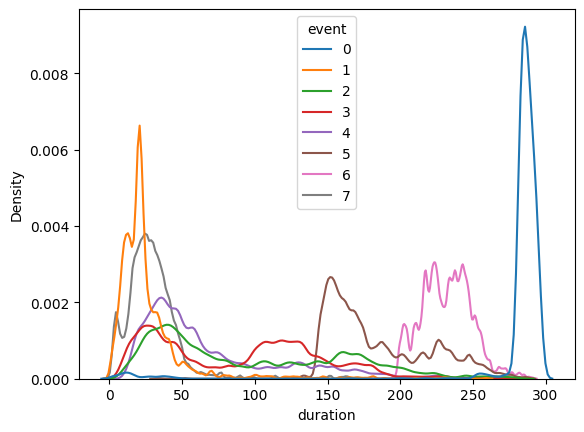

In [8]:
sns.kdeplot(data=y_train, x="duration", hue="event", bw_adjust=0.25, palette="tab10")

# Модели

##AalenJohansenFitter (lifelines)



In [ ]:
def transform_timegrid(curves, time, grid):
    ind = np.searchsorted(time, grid)
    if len(curves.shape)==1:
      return curves[ind]
    elif len(curves.shape)==2:
      return curves[:, ind]
    else:
      return None

ibs:        old time_grid      new time_grid
--------
ibs 1 :   0.22       0.22    
--------
ibs 9 :   0.20       0.20    
--------
ibs 96:   0.22       0.22    
--------
ibs 16:   0.10       0.10    
--------
ibs 3 :   0.19       0.19    
--------
ibs 2 :   0.19       0.19    
--------
ibs 15:   0.14       0.14    


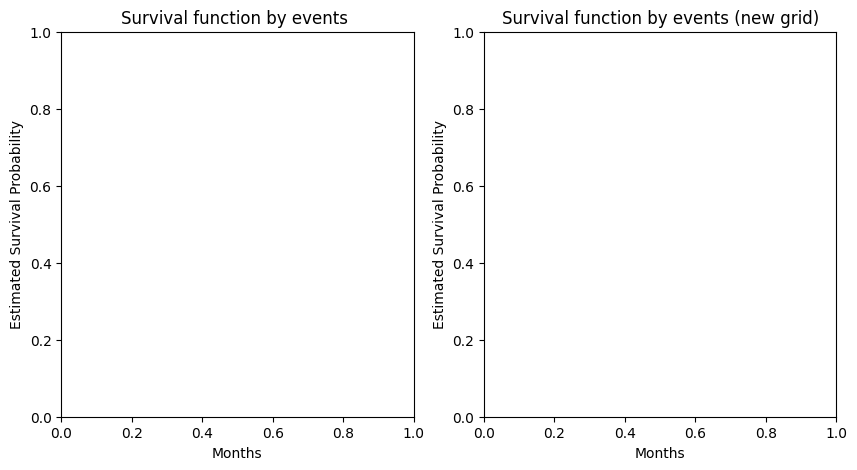

In [ ]:
aj = AalenJohansenFitter()
T, E = y_.duration, y_.event
print(f"ibs:        old time_grid      new time_grid")
for i in df.event.unique():
  if i:
    aj.fit(T, E, event_of_interest=i)
    print('--------')
    curve = 1-aj.cumulative_density_[f'CIF_{i}']
    new_curve = transform_timegrid(curve.values, aj.cumulative_density_.index, TIME_GRID).T.astype(float)
    # ibs of model with old time_grid

    ibs_1 = ibs_remain(get_y_event(y_train, [dct[i]]),
                      get_y_event(y_test, [dct[i]]),
                      np.repeat(curve.values[np.newaxis, :], y_test.shape[0], axis=0),
                      times=aj.cumulative_density_.index, axis=-1)

    # ibs of model with new time_grid
    ibs_2 = ibs_remain(get_y_event(y_train, [dct[i]]),
                      get_y_event(y_test, [dct[i]]),
                      np.repeat(new_curve[np.newaxis, :], y_test.shape[0], axis=0),
                      times=TIME_GRID, axis=-1)
    print(f"ibs {i:<2}:   {ibs_1:<4.2f}       {ibs_2:<8.2f}")

In [13]:
curve = 1-aj.cumulative_density_[f'CIF_{i}']
np.repeat(curve.values[np.newaxis, :], y_test.shape[0], axis=0)

array([[1.        , 0.99995833, 0.99991667, ..., 0.87469079, 0.87469079,
        0.87469079],
       [1.        , 0.99995833, 0.99991667, ..., 0.87469079, 0.87469079,
        0.87469079],
       [1.        , 0.99995833, 0.99991667, ..., 0.87469079, 0.87469079,
        0.87469079],
       ...,
       [1.        , 0.99995833, 0.99991667, ..., 0.87469079, 0.87469079,
        0.87469079],
       [1.        , 0.99995833, 0.99991667, ..., 0.87469079, 0.87469079,
        0.87469079],
       [1.        , 0.99995833, 0.99991667, ..., 0.87469079, 0.87469079,
        0.87469079]])

In [15]:
new_curve = transform_timegrid(curve, aj.cumulative_density_.index, TIME_GRID).T.astype(float)
np.repeat(curve.values[np.newaxis, :], y_test.shape[0], axis=0).shape

(4800, 21092)

In [35]:
ind = np.searchsorted(aj.cumulative_density_.index, TIME_GRID)
np.repeat(curve.values[np.newaxis, :], y_test.shape[0], axis=0)[:, ind].shape

(4800, 100)

In [30]:
ind

(100,)

In [125]:
new_curve.T

array([[0.9999583333333333, 0.9970412370634489, 0.9913730313741496, ...,
        0.8747024573594284, 0.8747024573594284, 0.8747024573594284]],
      dtype=object)

In [22]:
curve = 1-aj.cumulative_density_[f'CIF_{i}']
new_curve = transform_timegrid(curve, aj.cumulative_density_.index, TIME_GRID).T.astype(float)

In [23]:
new_curve.shape

(1, 21092)

## SurvivalBoost (hazardous)

In [63]:
survival_boost = SurvivalBoost(show_progressbar=True).fit(x_train.iloc[:, :-1], y_train)

100%|██████████| 100/100 [00:49<00:00,  2.02it/s]


In [64]:
x_ = x_test.iloc[:, :-1].copy()
x_.MSA.fillna(0, inplace=True)

1. **predict_survival_function** - предсказывает вероятность ненаступления любого из событий (т.е. функция выживания для любого события). Вычисляется на основе (2): predict_cumulative_incidence[:, 0, :]
2.**predict_cumulative_incidence** - кумулятивная функция риска для каждого типа событий, возвращает массив (n_samples, n_events + 1, n_times):
    *  array[:, 0, :] - вероятность отсутствия события( функция выживания для любого события (формула (*)))
    *   array[:, i, :] - cif_i, i=(0, 1, 2, 3, 9, 15, 16, 96)



(*) $$ S(t) = 1 - \sum_{k} cif_k$$

#### **predict_cumulative_incidence**

In [65]:
cif = survival_boost.predict_cumulative_incidence(x_, times=TIME_GRID)

100%|██████████| 100/100 [00:09<00:00, 10.38it/s]


In [66]:
cif.shape

(4800, 8, 100)

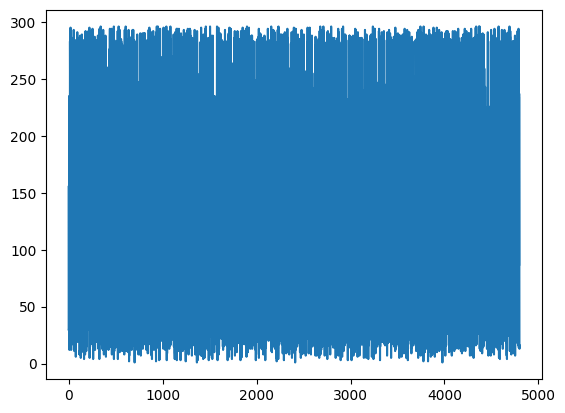

In [67]:
plt.plot(get_y_event(y_test, [1])["duration"])

In [68]:
np.bincount(get_y_event(y_test, [1])["event"])

array([4200,  600])

In [71]:
for i in range(len(sf)):
  if np.sum(sf[i]<0) > 0:
    print(i)

In [53]:
dct

{np.int64(0): 0,
 np.int64(1): 1,
 np.int64(2): 2,
 np.int64(3): 3,
 np.int64(9): 4,
 np.int64(15): 5,
 np.int64(16): 6,
 np.int64(96): 7}

ibs 1 :   0.1061
ibs 9 :   0.1395
ibs 96:   0.1687
ibs 16:   0.0755
ibs 3 :   0.1554
ibs 2 :   0.1868
ibs 15:   0.0664


Text(0, 0.5, 'Estimated Survival Probability')

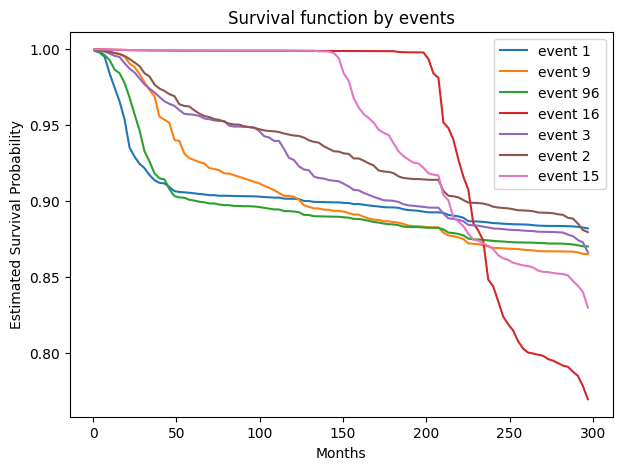

In [74]:
fig, axs = plt.subplots(figsize=(7, 5))
for i in df.event.unique():
  if i:
    sf = 1-cif[:, dct[i], :]
    # sf = transform_timegrid(sf, survival_boost.time_grid_, TIME_GRID)
    sf = transform_curves(sf)
    ibs =  ibs_remain(get_y_event(y_train, [dct[i]]),
                       get_y_event(y_test, [dct[i]]), sf,
                       times=TIME_GRID, axis=-1)
    print(f"ibs {i:<2}:   {ibs:<4.4f}")
    axs.plot(TIME_GRID, sf.mean(axis=0), label=(f"event {i}"))
axs.legend()
axs.set_title(f"Survival function by events")
axs.set_xlabel("Months")
axs.set_ylabel("Estimated Survival Probability")

#### **predict_survival_function**

100%|██████████| 100/100 [00:08<00:00, 11.47it/s]


        old time_grid      new time_grid


NameError: name 'curves_new' is not defined

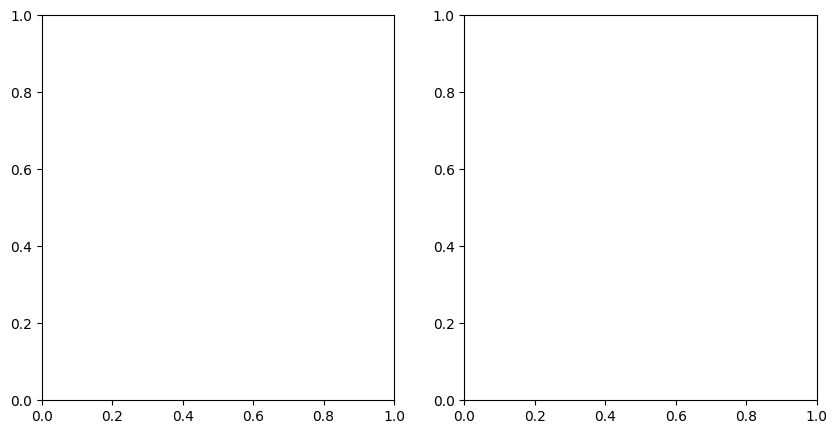

In [ ]:
curves = survival_boost.predict_survival_function(x_, times=TIME_GRID)
curves = transform_curves(curves)
# curves_new = transform_timegrid(curves, survival_boost.time_grid_, TIME_GRID)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
scores=[]
print('        old time_grid      new time_grid')
for i in df.event.unique():
  if i:
    mask = y_test["event"] == dct[i]
    mean_survival = curves[mask].mean(axis=0)
    # sf = transform_timegrid(mean_survival, survival_boost.time_grid_, TIME_GRID)
    sf = transform_curves(sf)

    ibs_1 = ibs_remain(get_y_event(y_train, [dct[i]]),
                       get_y_event(y_test, [dct[i]]), curves,
                       times=survival_boost.time_grid_, axis=-1)

    ibs_2 = ibs_remain(get_y_event(y_train, [dct[i]]),
                       get_y_event(y_test, [dct[i]]), curves,
                       times=TIME_GRID, axis=-1)
    print(f"ibs {ev:<2}:   {ibs_1:<4.2f}                 {ibs_2:<8.2f}")

    #scores.append(ibs_)
    #print(f"ibs {ev}: {ibs_}")
    axs[0].plot(
        survival_boost.time_grid_,
        mean_survival,
        label=(f"event {i}"),
    )

    axs[1].plot(TIME_GRID, sf, label=(f"event {ev}"))
# ibs_ = ibs_remain(get_y_event(y_train, sorted(df.event.unique())[1:]),
#                   get_y_event(y_test, sorted(df.event.unique())[1:]), curves_new, times=TIME_GRID, axis=-1)
# scores.append(ibs_)
# print('---------\n', f"ibs: {ibs_:.2f}")
# ibs['SurvivalBoost']=scores
for i in (0, 1):
  axs[i].set_title(f"Survival function by events {i*'(new grid)'}")
  axs[i].set_xlabel("Months")
  axs[i].set_ylabel("Estimated Survival Probability")

plt.show()

## DeepHit (pycox)

In [84]:
get_x = lambda df: (df.values.astype('float32'))
get_target = lambda df: (df['duration'].values, df['event'].values)


class LabTransform(LabTransDiscreteTime):
    def transform(self, durations, events):
        durations, is_event = super().transform(durations, events > 0)
        events[is_event == 0] = 0
        return durations, events.astype('int64')


class CauseSpecificNet(torch.nn.Module):
    """Network structure similar to the DeepHit paper, but without the residual
    connections (for simplicity).
    """
    def __init__(self, in_features, num_nodes_shared, num_nodes_indiv, num_risks,
                 out_features, batch_norm=True, dropout=None):
        super().__init__()
        self.shared_net = tt.practical.MLPVanilla(
            in_features, num_nodes_shared[:-1], num_nodes_shared[-1],
            batch_norm, dropout,
        )
        self.risk_nets = torch.nn.ModuleList()
        for _ in range(num_risks):
            net = tt.practical.MLPVanilla(
                num_nodes_shared[-1], num_nodes_indiv, out_features,
                batch_norm, dropout,
            )
            self.risk_nets.append(net)

    def forward(self, input):
        out = self.shared_net(input)
        out = [net(out) for net in self.risk_nets]
        out = torch.stack(out, dim=1)
        return out

In [ ]:
x_val.MSA.fillna(0, inplace=True)
x_test.MSA.fillna(0, inplace=True)
x_train.MSA.fillna(0, inplace=True)

# y_train, dct = transform_events(y_train)
# y_test, _ = transform_events(y_test)
# y_val, _ = transform_events(y_val)

labtrans = LabTransform(100)
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train_ = labtrans.fit_transform(*get_target(y_train.sort_values(by='duration')))
y_val = labtrans.transform(*get_target(y_val))
durations_test, events_test = get_target(y_test)
x_train = get_x(x_train.iloc[:,:-1])
x_val = get_x(x_val.iloc[:,:-1])
x_test = get_x(x_test.iloc[:,:-1])
val = (x_val, y_val)
train = (x_train, y_train_)

AttributeError: 'numpy.ndarray' object has no attribute 'MSA'

In [110]:
in_features = x_train.shape[1]
num_nodes_shared = [64, 64]
num_nodes_indiv = [32]
num_risks = y_train_[1].max()
out_features = len(labtrans.cuts)
batch_norm = True
dropout = 0.3

# net = SimpleMLP(in_features, num_nodes_shared, num_risks, out_features)
net = CauseSpecificNet(in_features, num_nodes_shared, num_nodes_indiv, num_risks,
                       out_features, batch_norm, dropout)
optimizer = tt.optim.AdamWR(lr=0.001, decoupled_weight_decay=0.01,
                            cycle_eta_multiplier=0.8)
model = DeepHit(net, optimizer, alpha=0.2, sigma=0.1,
                duration_index=labtrans.cuts)

In [111]:
epochs = 512
batch_size = 128
callbacks = [tt.callbacks.EarlyStoppingCycle()]
verbose = True
#x_train_ = x_train_.astype('int64')
log = model.fit(x_train, y_train_, batch_size, epochs, callbacks, verbose, val_data=val)

0:	[1s / 1s],		train_loss: 1.6331,	val_loss: 1.6422
1:	[1s / 2s],		train_loss: 1.6078,	val_loss: 1.5945
2:	[1s / 3s],		train_loss: 1.5889,	val_loss: 1.5929
3:	[1s / 5s],		train_loss: 1.5777,	val_loss: 1.6134
4:	[1s / 6s],		train_loss: 1.5559,	val_loss: 1.5574
5:	[1s / 7s],		train_loss: 1.5433,	val_loss: 1.5491
6:	[1s / 9s],		train_loss: 1.5378,	val_loss: 1.5490
7:	[1s / 10s],		train_loss: 1.5313,	val_loss: 1.5292
8:	[1s / 11s],		train_loss: 1.5110,	val_loss: 1.6224
9:	[1s / 12s],		train_loss: 1.4943,	val_loss: 1.4979
10:	[1s / 13s],		train_loss: 1.4825,	val_loss: 1.4881
11:	[1s / 14s],		train_loss: 1.4742,	val_loss: 1.4812
12:	[1s / 16s],		train_loss: 1.4676,	val_loss: 1.4780
13:	[1s / 17s],		train_loss: 1.4671,	val_loss: 1.4777
14:	[1s / 18s],		train_loss: 1.4655,	val_loss: 1.4771
15:	[1s / 19s],		train_loss: 1.4611,	val_loss: 1.4678
16:	[1s / 21s],		train_loss: 1.4523,	val_loss: 1.4608
17:	[1s / 22s],		train_loss: 1.4464,	val_loss: 1.4542
18:	[1s / 23s],		train_loss: 1.4409,	val_loss

In [104]:
cif = model.predict_cif(x_test)

cif - трехмерный массив размера (96, 100, 4800), где

*   axis=0 - тип события, от 0 до 95 (используется только 8, zero_code -1 соотв.)
*   axis=1 - временная шкала
*   axis=2 - соответствующие наблюдения



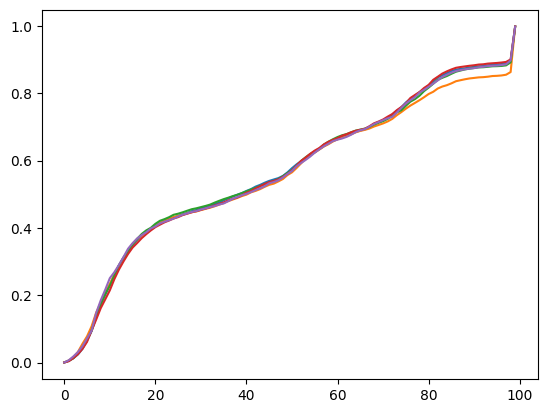

In [105]:
plt.plot(cif.sum(axis=0)[:, :5])

In [106]:
def surv_func_1(cif, event_of_interest=1):
  return 1-(cif.transpose()[..., event_of_interest-1])

def surv_func_2(cif, event_of_interest=1):
  return 1 - (cif[df.event.unique()-1].sum(axis=0).T - (cif.transpose()[..., event_of_interest-1]))

def surv_func_3(cif, event_of_interest=1):
  return 1 - (cif.sum(axis=0).T - (cif.transpose()[..., event_of_interest-1]))

1. sf 1:  $$ S_k(t) = 1 - cif_k$$
1. sf 2:  $$ S_k(t) = 1 - \sum_{i!=k} cif_k, i\in (1, 2, 3, 9, 15, 16, 96)$$
1. sf 3:  $$ S_k(t) = 1 - \sum_{i=0, i!=k}^{95} cif_k$$

        1-cif_k      1-summ(cif_i)
ibs 1 :   0.22         0.21    
ibs 9 :   0.20         0.21    
ibs 96:   0.22         0.21    
ibs 16:   0.10         0.27    
ibs 3 :   0.19         0.21    
ibs 2 :   0.19         0.21    
ibs 15:   0.14         0.24    
---------
 ibs: 0.49


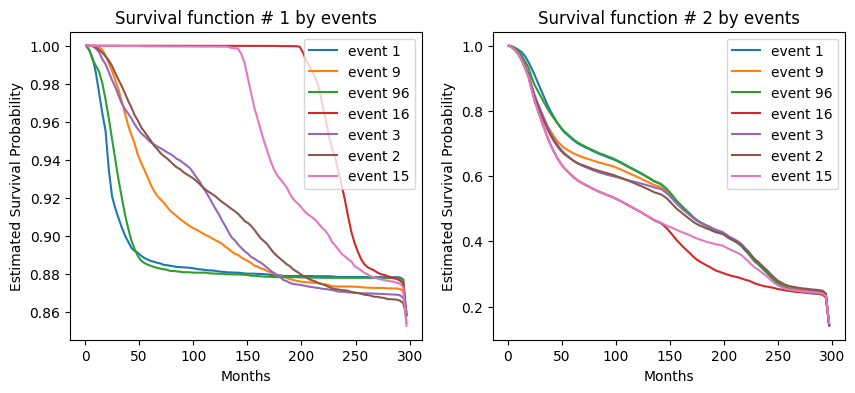

In [107]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
scores=[]
summ=np.empty(shape=model.duration_index.shape)
y_tmp = pd.DataFrame({'event': y_train_[1], 'duration': y_train_[0]})
#print('       до преобр.    после преобр.')
print('        1-cif_k      1-summ(cif_i)')
for i in df.event.unique():
  if i:

    sf1 = transform_timegrid(surv_func_1(cif, dct[i]), model.duration_index, TIME_GRID)
    sf2 = transform_timegrid(surv_func_3(cif, dct[i]), model.duration_index, TIME_GRID)

    ibs_1 = ibs_remain(get_y_event(y_tmp, [dct[i]]),
                      get_y_event(y_test, [dct[i]]),
                      sf1, times=TIME_GRID, axis=-1)

    ibs_2 = ibs_remain(get_y_event(y_tmp, [dct[i]]),
                      get_y_event(y_test, [dct[i]]),
                      sf2, times=TIME_GRID, axis=-1)
    print(f"ibs {i:<2}:   {ibs_1:<4.2f}         {ibs_2:<8.2f}")
    axs[0].plot(TIME_GRID,
          sf1.mean(axis=0),
          label=f"event {i}")
    axs[1].plot(TIME_GRID,
          sf2.mean(axis=0),
          label=f"event {i}")

est = transform_timegrid(cif.transpose()[..., sorted(y_train.event.unique())[:-1]].mean(axis=2),
              model.duration_index, TIME_GRID)

ibs_ = ibs_remain(get_y_event(y_tmp, sorted(df.event.unique())[1:]),
                  get_y_event(y_test, sorted(df.event.unique())[1:]),
                  est, TIME_GRID, axis=-1)

print('---------\n', f"ibs: {ibs_:.2f}")
# ibs['DeepHit']=scores
for i in (0, 1):
  axs[i].legend()
  axs[i].set_title(f"Survival function # {i+1} by events")
  axs[i].set_xlabel("Months")
  axs[i].set_ylabel("Estimated Survival Probability")

plt.show()

Здесь использовалось линейное преобразование  оси Y в [0, 1], т.к. cif_k <= 0.12 (+-) (т.к. $\sum_{k}cif_k + S(t) = 1$) (Аналогично в AalenJohansen, но там осталось 0.12)

---

ниже график S(t)

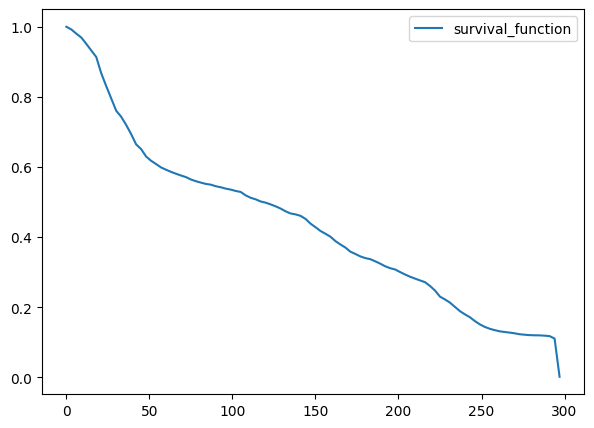

In [92]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(model.duration_index,
          1-summ,
          label=f"survival_function")
ax.legend()
plt.show()

## IBS

In [39]:
def ibs_remain(survival_train, survival_test, estimate, times, axis=-1):
    """ IBS with equal impact of partial observation with controlled quantity """
    test_event, test_time = check_y_survival(survival_test, allow_all_censored=True)
    estimate = np.array(estimate)
    if estimate.ndim == 1 and times.shape[0] == 1:
        estimate = estimate.reshape(-1, 1)
    estimate[estimate == -np.inf] = 0
    estimate[estimate == np.inf] = 0

    estim_before = np.square(estimate) * test_event[np.newaxis, :].T
    estim_after = np.square(1 - estimate)
    brier_scores = np.array([np.where(test_time < t,
                                      estim_before[:, i],
                                      estim_after[:, i])
                             for i, t in enumerate(times)])
    N = np.sum(np.array([np.where(test_time < t, test_event, 1)
                         for i, t in enumerate(times)]), axis=1)
    time_diff = times[-1] - times[0] if times[-1] > times[0] else 1
    if axis == -1:  # mean ibs for each time and observation
        # brier_scores = np.mean(brier_scores, axis=1)
        brier_scores = np.where(N > 0, 1 / N, 0) * np.sum(brier_scores, axis=1)
        return np.trapz(brier_scores, times) / time_diff
    elif axis == 0:  # ibs for each observation
        return np.trapz(brier_scores, times, axis=0) / time_diff
    elif axis == 1:  # bs in time (for graphics)
        # brier_scores = np.mean(brier_scores, axis=1)
        brier_scores = np.where(N > 0, 1 / N, 0) * np.sum(brier_scores, axis=1)
        return brier_scores
    return None

In [ ]:
#ibs_tab = pd.DataFrame(ibs, index=[f'ibs_{i}' for i in sorted(df.event.unique())[1:]]+['IBS'])
#ibs_tab